<a href="https://colab.research.google.com/github/ShuaiWangAI/TIL-Programming-Group-06-Mid-term-Report/blob/main/Overspeed_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

## `Import library`

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sb
# import scienceplots
%matplotlib inline
import sqlite3
import sklearn
from sklearn.cluster import KMeans

## `Load speed dataset`

In [4]:
# mount to Google Drive directory
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# path = 'drive/MyDrive/Documents/HTM_dataset'
path = 'drive/MyDrive/Design Project - HTM/HTM_dataset'

speed_df = pd.read_csv(path + '/speed_365days.csv',
                       index_col=0,
                       parse_dates=['hfk_in', 'hfk_uit'])

# rename the columns
speed_df.columns = [
    'line', 'vehicle', 'category', 'service', 'wissel_number', 'direction',
    'hfk_in', 'hfk_uit', 'speed', 'code']

# filter the tramline
speed_df = speed_df[speed_df["line"].isin(
    [1, 2, 3, 4, 6, 9, 11, 12, 15, 16, 17, 19, 34])]
speed_df = speed_df[speed_df["speed"] > 0]
speed_df = speed_df[speed_df['direction'].isin(
    ['Recht door', ' links af', ' rechts af'])]

# reset the dtypes of column
speed_df['line'] = speed_df['line'].astype('int32')
speed_df['vehicle'] = speed_df['vehicle'].astype('int32')
speed_df['speed'] = speed_df['speed'].astype('int32')
speed_df['category'] = speed_df['category'].astype('category')

# add new columns
# duration over the wissel
speed_df['duration'] = speed_df['hfk_uit'] - speed_df['hfk_in']
# go straightForward or turning
speed_df['is_straight'] = speed_df["direction"] == 'Recht door'
# date and time
speed_df['year'] = speed_df['hfk_in'].dt.year
speed_df['month'] = speed_df['hfk_in'].dt.month
speed_df['day'] = speed_df['hfk_in'].dt.day
speed_df['hour'] = speed_df['hfk_in'].dt.hour
speed_df['minute'] = speed_df['hfk_in'].dt.minute

# only use year 2023
year = 2023
speed_df = speed_df[speed_df['year'] == year]

# remove useless columns
speed_df = speed_df.drop(['code', 'service'], axis=1)

speed_df.head(3)

,line,vehicle,category,wissel_number,direction,hfk_in,hfk_uit,speed,duration,is_straight,year,month,day,hour,minute
0,11,5008,0.0,W003,Recht door,2023-01-01 08:52:44.340,2023-01-01 08:52:50.980,19,0 days 00:00:06.640000,True,2023,1,1,8,52
1,11,5022,0.0,W003,Recht door,2023-01-01 09:11:48.060,2023-01-01 09:11:54.820,19,0 days 00:00:06.760000,True,2023,1,1,9,11
2,11,5038,0.0,W003,Recht door,2023-01-01 09:31:47.460,2023-01-01 09:31:54.630,18,0 days 00:00:07.170000,True,2023,1,1,9,31


In [6]:
speed_df["wissel_number"].unique().shape

(132,)

In [7]:
print(f"Include {speed_df.groupby(['year', 'month']).count().index.to_list()}")

Include [(2023, 1), (2023, 2), (2023, 3), (2023, 4), (2023, 5), (2023, 6), (2023, 7), (2023, 8), (2023, 9), (2023, 10), (2023, 11)]


## `Join GPS data`

In [8]:
# load the latitude and longitude of all wissels
gps_wissels_df = pd.read_csv(path + '/gps_info.csv', sep=';')
print(f'In total, {gps_wissels_df.shape[0]} wissels with info of {gps_wissels_df.columns.tolist()}')

def to_decimal_degree_lat(coordinate):
    str_seq = str(coordinate).replace('.', '')
    num_seq = float(str_seq)
    return num_seq / 10**(len(str_seq) - 2)

def to_decimal_degree_lon(coordinate):
    str_seq = str(coordinate).replace('.', '')
    num_seq = float(str_seq)
    return num_seq / 10**(len(str_seq) - 1)

gps_wissels_df['latitude'] = gps_wissels_df['latitude'].apply(to_decimal_degree_lat)
gps_wissels_df['longitude'] = gps_wissels_df['longitude'].apply(to_decimal_degree_lon)

speed_df = speed_df.merge(right=gps_wissels_df,
                                    # on='Wissel Nr'
                                    left_on='wissel_number', right_on='Wissel Nr',
                                    # how='left'
                                   )
speed_df = speed_df.dropna()
print(f"Joined dataset shape : {speed_df.shape}")
print("Joined dataset columns:\n", speed_df.columns.to_list())
speed_df.head()

In total, 230 wissels with info of ['Wissel Nr', 'latitude', 'longitude']
Joined dataset shape : (5135734, 18)
Joined dataset columns:
 ['line', 'vehicle', 'category', 'wissel_number', 'direction', 'hfk_in', 'hfk_uit', 'speed', 'duration', 'is_straight', 'year', 'month', 'day', 'hour', 'minute', 'Wissel Nr', 'latitude', 'longitude']


,line,vehicle,category,wissel_number,direction,hfk_in,hfk_uit,speed,duration,is_straight,year,month,day,hour,minute,Wissel Nr,latitude,longitude
0,11,5008,0.0,W003,Recht door,2023-01-01 08:52:44.340,2023-01-01 08:52:50.980,19,0 days 00:00:06.640000,True,2023,1,1,8,52,W003,52.101527,4.274058
1,11,5022,0.0,W003,Recht door,2023-01-01 09:11:48.060,2023-01-01 09:11:54.820,19,0 days 00:00:06.760000,True,2023,1,1,9,11,W003,52.101527,4.274058
2,11,5038,0.0,W003,Recht door,2023-01-01 09:31:47.460,2023-01-01 09:31:54.630,18,0 days 00:00:07.170000,True,2023,1,1,9,31,W003,52.101527,4.274058
3,11,5008,0.0,W003,Recht door,2023-01-01 09:51:16.150,2023-01-01 09:51:23.030,18,0 days 00:00:06.880000,True,2023,1,1,9,51,W003,52.101527,4.274058
4,11,5022,0.0,W003,Recht door,2023-01-01 10:11:25.480,2023-01-01 10:11:33.440,16,0 days 00:00:07.960000,True,2023,1,1,10,11,W003,52.101527,4.274058


## `Get over-speed data`

In [9]:
speedLimit_straight = 15 # km/h
speedLimit_turning  = 15 # km/h

overspeed_straight_df = speed_df[
    (speed_df['is_straight'] == True) & (speed_df['speed'] >= speedLimit_straight)
]
# overspeed_straight_df['difference'] = 0
overspeed_straight_df['difference'] = overspeed_straight_df['speed'] - speedLimit_straight

overspeed_turning_df = speed_df[
    (speed_df['is_straight'] == False) & (speed_df['speed'] >= speedLimit_turning)
]
# overspeed_turning_df['difference'] = 0
overspeed_turning_df['difference'] = overspeed_turning_df['speed'] - speedLimit_turning

overspeed_df = pd.concat([overspeed_straight_df, overspeed_turning_df])
assert len(overspeed_df) == len(overspeed_straight_df) + len(overspeed_turning_df)
print(f"Size of the full over-speed dataset: {len(overspeed_df)} samples.")
print(f"Size of straight over-speed dataset: {len(overspeed_straight_df)} samples.")
print(f"Size of turning  over-speed dataset: {len(overspeed_turning_df)} samples.")

<ipython-input-9-6fae27109660>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_straight_df['difference'] = overspeed_straight_df['speed'] - speedLimit_straight
<ipython-input-9-6fae27109660>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overspeed_turning_df['difference'] = overspeed_turning_df['speed'] - speedLimit_turning


Size of the full over-speed dataset: 3485154 samples.
Size of straight over-speed dataset: 2432490 samples.
Size of turning  over-speed dataset: 1052664 samples.


In [10]:
overspeed_df.head(3)

,line,vehicle,category,wissel_number,direction,hfk_in,hfk_uit,speed,duration,is_straight,year,month,day,hour,minute,Wissel Nr,latitude,longitude,difference
0,11,5008,0.0,W003,Recht door,2023-01-01 08:52:44.340,2023-01-01 08:52:50.980,19,0 days 00:00:06.640000,True,2023,1,1,8,52,W003,52.101527,4.274058,4
1,11,5022,0.0,W003,Recht door,2023-01-01 09:11:48.060,2023-01-01 09:11:54.820,19,0 days 00:00:06.760000,True,2023,1,1,9,11,W003,52.101527,4.274058,4
2,11,5038,0.0,W003,Recht door,2023-01-01 09:31:47.460,2023-01-01 09:31:54.630,18,0 days 00:00:07.170000,True,2023,1,1,9,31,W003,52.101527,4.274058,3


# Data analysis

## Descriptive statistics

In [11]:
overspeed_df['speed']

0          19
1          19
2          18
3          18
4          16
           ..
5098233    16
5098234    16
5098235    19
5098239    15
5098261    18
Name: speed, Length: 3485154, dtype: int32

In [12]:
overspeed_df["speed"].unique().shape

(35,)

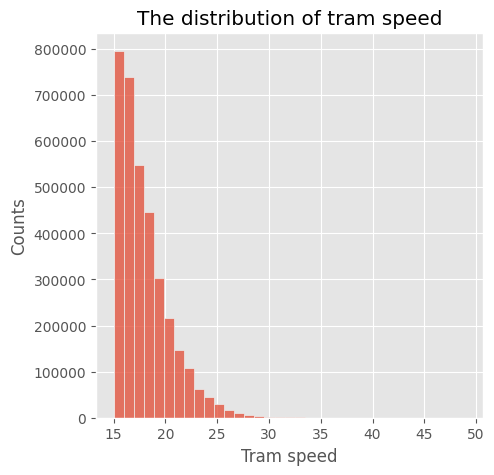

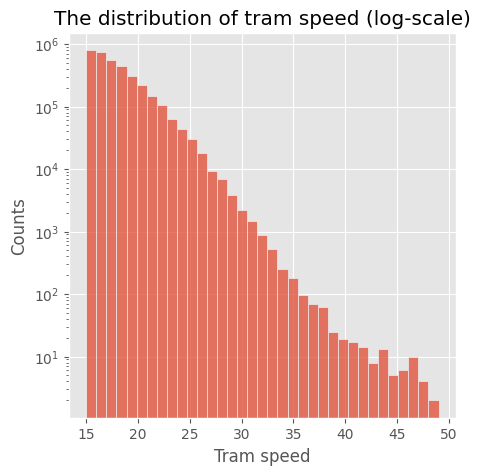

In [13]:
plt.figure(figsize=(5, 5))
fig = sb.histplot(
    data=overspeed_df,
    x='speed',
    bins=35,
)

# fig.set_yscale("log")
plt.title("The distribution of tram speed")
plt.ylabel('Counts')
plt.xlabel('Tram speed')
plt.show()

plt.figure(figsize=(5, 5))
fig = sb.histplot(
    data=overspeed_df,
    x='speed',
    bins=35,
)
fig.set_yscale("log")

# fig.set_yscale("log")
plt.title("The distribution of tram speed (log-scale)")
plt.ylabel('Counts')
plt.xlabel('Tram speed')
plt.show()

In [14]:
overspeed_straight_df['speed'].describe()

count    2.432490e+06
mean     1.792407e+01
std      2.769189e+00
min      1.500000e+01
25%      1.600000e+01
50%      1.700000e+01
75%      1.900000e+01
max      4.900000e+01
Name: speed, dtype: float64

In [15]:
overspeed_turning_df['speed'].describe()

count    1.052664e+06
mean     1.665099e+01
std      1.708704e+00
min      1.500000e+01
25%      1.500000e+01
50%      1.600000e+01
75%      1.800000e+01
max      4.900000e+01
Name: speed, dtype: float64

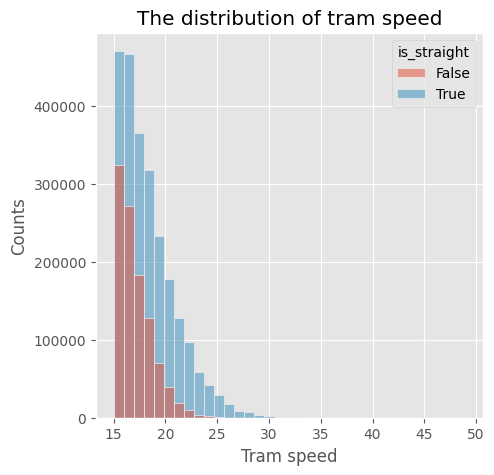

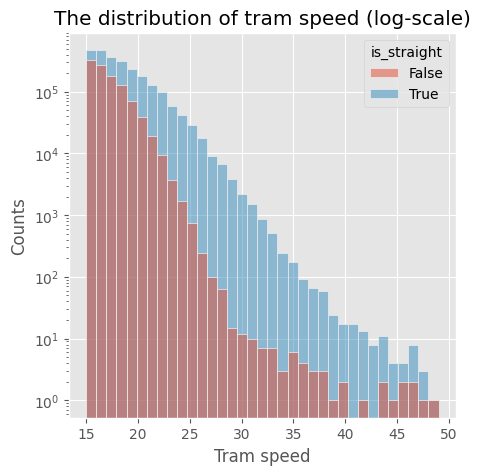

In [16]:
plt.figure(figsize=(5, 5))
fig = sb.histplot(
    data=overspeed_df,
    x='speed',
    hue='is_straight',
    bins=35,
)

# fig.set_yscale("log")
plt.title("The distribution of tram speed")
plt.ylabel('Counts')
plt.xlabel('Tram speed')
plt.show()

plt.figure(figsize=(5, 5))
fig = sb.histplot(
    data=overspeed_df,
    x='speed',
    hue='is_straight',
    bins=35,
)
fig.set_yscale("log")

# fig.set_yscale("log")
plt.title("The distribution of tram speed (log-scale)")
plt.ylabel('Counts')
plt.xlabel('Tram speed')
plt.show()

## Cluster analysis (severity-based)

### Elbow method

In [17]:
overspeed_df.head()

,line,vehicle,category,wissel_number,direction,hfk_in,hfk_uit,speed,duration,is_straight,year,month,day,hour,minute,Wissel Nr,latitude,longitude,difference
0,11,5008,0.0,W003,Recht door,2023-01-01 08:52:44.340,2023-01-01 08:52:50.980,19,0 days 00:00:06.640000,True,2023,1,1,8,52,W003,52.101527,4.274058,4
1,11,5022,0.0,W003,Recht door,2023-01-01 09:11:48.060,2023-01-01 09:11:54.820,19,0 days 00:00:06.760000,True,2023,1,1,9,11,W003,52.101527,4.274058,4
2,11,5038,0.0,W003,Recht door,2023-01-01 09:31:47.460,2023-01-01 09:31:54.630,18,0 days 00:00:07.170000,True,2023,1,1,9,31,W003,52.101527,4.274058,3
3,11,5008,0.0,W003,Recht door,2023-01-01 09:51:16.150,2023-01-01 09:51:23.030,18,0 days 00:00:06.880000,True,2023,1,1,9,51,W003,52.101527,4.274058,3
4,11,5022,0.0,W003,Recht door,2023-01-01 10:11:25.480,2023-01-01 10:11:33.440,16,0 days 00:00:07.960000,True,2023,1,1,10,11,W003,52.101527,4.274058,1


#### Year 2023

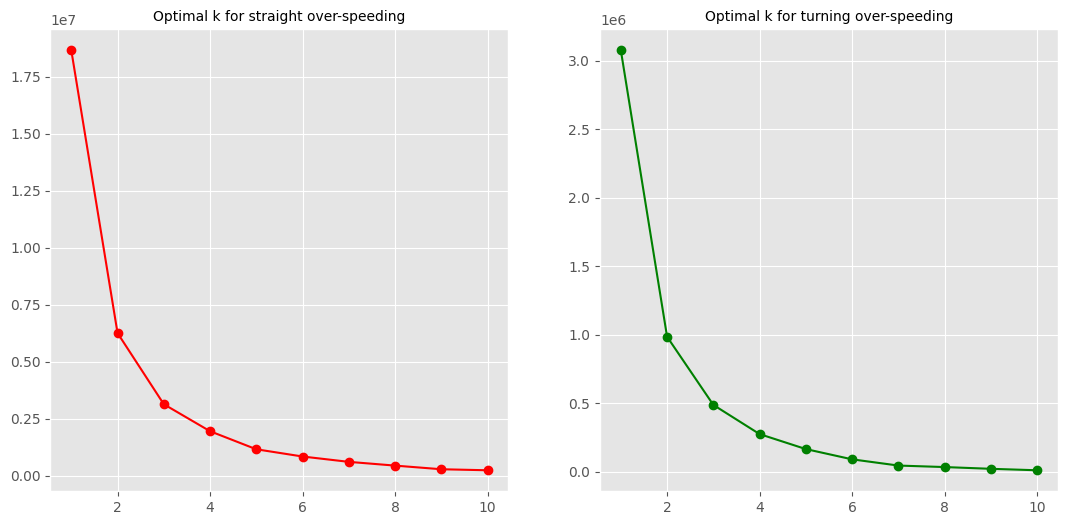

In [18]:
year = 2023
fig, axs = plt.subplots(1,2,figsize=(13, 6), sharex=True, sharey=False)
for col_idx in range(2):
    # Elbow method:
    num_clusters_range = range(1,11)
    sse = []
    for n_clusters in num_clusters_range:
        kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
        if col_idx == 0:
            df = overspeed_straight_df[overspeed_straight_df['year'] == year]
            c = 'red'
            dataset = "straight over-speeding"
        else:
            df = overspeed_turning_df[overspeed_turning_df['year'] == year]
            c = 'green'
            dataset = "turning over-speeding"
        df['cluster'] = kmeans.fit_predict(
            df[['latitude', 'longitude', 'difference']]
        )
        sse.append(kmeans.inertia_)
    axs[col_idx].plot(num_clusters_range, sse, marker='o', c=c)
    axs[col_idx].set_title(
        f"Optimal k for {dataset}",
        {'fontsize' : 10}
        )
plt.show()


#### For Three Time Periods

In [19]:
# first_date = '2023-3-30'
# second_date = '2023-8-30'

# year = 2023
# fig, axs = plt.subplots(3,3,figsize=(13, 13), sharex=True, sharey=False)
# for row_idx, period in enumerate(['Period 1', 'Period 2', 'Period 3']):
#     for col_idx in range(3):
#         # Elbow method:
#         num_clusters_range = range(1,11)
#         sse = []
#         for n_clusters in num_clusters_range:
#             kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
#             if col_idx == 0:
#                 df = overspeed_df[overspeed_df['year'] == year]
#                 c = 'red'
#                 dataset = "all over-speeding"
#             elif col_idx == 1:
#                 df = overspeed_straight_df[overspeed_straight_df['year'] == year]
#                 c = 'blue'
#                 dataset = "straight over-speeding"
#             else:
#                 df = overspeed_turning_df[overspeed_turning_df['year'] == year]
#                 c = 'green'
#                 dataset = "turning over-speeding"
#             if row_idx == 0:
#                 df = df[(df["hfk_in"] < pd.to_datetime(first_date))]
#             elif row_idx == 1:
#                 df = df[(pd.to_datetime(first_date) <= df["hfk_in"]) &
#                         (df["hfk_in"] < pd.to_datetime(second_date))]
#             else:
#                 df = df[(df["hfk_in"] >= pd.to_datetime(second_date))]
#             df['cluster'] = kmeans.fit_predict(
#                 df[['latitude', 'longitude', 'difference']]
#             )
#             sse.append(kmeans.inertia_)
#         axs[row_idx, col_idx].plot(num_clusters_range, sse, marker='o', c=c)
#         axs[row_idx, col_idx].set_title(
#             f"Optimal k for {period} of {dataset}",
#             {'fontsize' : 10}
#             )
# plt.show()

### Cluster by K-means

#### Year 2023 - Straight Over-speeding

In [ ]:
year = 2023
overspeed_df_straight2023 = overspeed_straight_df[overspeed_straight_df['year'] == year]
n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_df_straight2023['cluster'] = kmeans.fit_predict(
    overspeed_df_straight2023[['latitude', 'longitude', 'difference']]
    )

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_df_straight2023['longitude'],
            overspeed_df_straight2023['latitude'],
            c=overspeed_df_straight2023['cluster'],
            cmap='rainbow',
            s=10)
plt.title('Straight over-speeding clustering in 2023')
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(overspeed_df_straight2023['latitude'], overspeed_df_straight2023['longitude'],
           overspeed_df_straight2023['difference'],
           c=overspeed_df_straight2023['cluster'],
           s=overspeed_df_straight2023['difference']*1,
           cmap='rainbow'
           )

ax.view_init(elev=25, azim=45)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
#plt.title("Straight over-speeding clustering in 2023")
plt.show()

In [ ]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

In [ ]:
labels = kmeans.labels_
labels

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
cluster_counts

In [ ]:
for cluster_id, count in cluster_counts.items():
    center = cluster_centers[cluster_id]
    print(f"Cluster {cluster_id}, Center: {center}, Points in cluster: {count}")

In [ ]:
overspeed_df_straight2023.head()

In [ ]:
# import folium
# !pip install selenium
# import selenium
# import io
# from PIL import Image

# # Calculate average latitude and longtitude
# average_latitude = overspeed_df_straight2023['latitude'].mean()
# average_longitude = overspeed_df_straight2023['longitude'].mean()

# print("Average Latitude:", average_latitude)
# print("Average Longitude:", average_longitude)

# # Create a map object, set the initial location and zoom level
# map_combine = folium.Map(location=[average_latitude, average_longitude], zoom_start=12)

# # # Add cluster centers as special markers
# # for i in range(len(kmeans.cluster_centers_)):
# #     folium.Marker(
# #         [kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]],
# #         icon=folium.Icon(color='red', icon='info-sign')
# #     ).add_to(map_combine)

# # Add data points based on clustering results
# for index, row in overspeed_df_straight2023.iterrows():
#     if row['cluster'] == 0:
#       color = 'red'
#     elif row['cluster'] == 1:
#       color = 'blue'
#     else:
#       color = 'green'
#     folium.CircleMarker(
#         [row['latitude'], row['longitude']],
#         radius=5,
#         color=color,
#         fill=True,
#         popup=f"Speed: {row['speed']} km/h" # Show speed on map
#     ).add_to(map_combine)

# Display the map
# map_combine
# img_data = map_combine._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save("/content/drive/My Drive/MyImages/clustering_straight_2023_map.png")

#### Year 2023 - Turning Over-speeding

In [ ]:
year = 2023
overspeed_df_turning2023 = overspeed_turning_df[overspeed_turning_df['year'] == year]
n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_df_turning2023['cluster'] = kmeans.fit_predict(
    overspeed_df_turning2023[['latitude', 'longitude', 'difference']]
    )

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_df_turning2023['longitude'],
            overspeed_df_turning2023['latitude'],
            c=overspeed_df_turning2023['cluster'],
            cmap='rainbow',
            s=10)
plt.title('Turning over-speeding clustering in 2023')
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(overspeed_df_turning2023['latitude'], overspeed_df_turning2023['longitude'],
           overspeed_df_turning2023['difference'],
           c=overspeed_df_turning2023['cluster'],
           s=overspeed_df_turning2023['difference']*1,
           cmap='rainbow'
           )

ax.view_init(elev=25, azim=45)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
#plt.title("Turning over-speeding clustering in 2023")
plt.show()

In [ ]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

In [ ]:
labels = kmeans.labels_
labels

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
cluster_counts

In [ ]:
for cluster_id, count in cluster_counts.items():
    center = cluster_centers[cluster_id]
    print(f"Cluster {cluster_id}, Center: {center}, Points in cluster: {count}")

In [ ]:
import folium

# Calculate average latitude and longtitude
average_latitude = overspeed_df_turning2023['latitude'].mean()
average_longitude = overspeed_df_turning2023['longitude'].mean()

print("Average Latitude:", average_latitude)
print("Average Longitude:", average_longitude)

# Create a map object, set the initial location and zoom level
map_combine = folium.Map(location=[average_latitude, average_longitude], zoom_start=12)

# Add cluster centers as special markers
for i in range(len(kmeans.cluster_centers_)):
    folium.Marker(
        [kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map_combine)

# Add data points based on clustering results
for index, row in overspeed_df_turning2023.iterrows():
    if row['cluster'] == 0:
      color = 'red'
    elif row['cluster'] == 1:
      color = 'blue'
    else:
      color = 'green'
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        popup=f"Speed: {row['speed']} km/h" # Show speed on map
    ).add_to(map_combine)

# Display the map
# map_combine

In [ ]:
# img_data = map_combine._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save("/content/drive/My Drive/MyImages/clustering_turning_2023_map.png")

#### Period 1 - all over-speed

In [ ]:
# overspeed_df_p1 = overspeed_df[overspeed_df["hfk_in"] <= pd.to_datetime(first_date)]
# n_clusters = 3
# # fit the model
# kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
# overspeed_df_p1['cluster'] = kmeans.fit_predict(
#     overspeed_df_p1[['latitude', 'longitude', 'difference']]
#     )

# fig, ax = plt.subplots(figsize=(5,5))
# plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
# plt.scatter(overspeed_df_p1['longitude'],
#             overspeed_df_p1['latitude'],
#             c=overspeed_df_p1['cluster'],
#             cmap='hsv',
#             s=10)
# plt.title('All over-speeding clustering in period 1')
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(overspeed_df_p1['latitude_x'], overspeed_df_p1['longitude_x'],
#            overspeed_df_p1['difference'],
#            c=overspeed_df_p1['cluster'],
#            s=overspeed_df_p1['difference']*1
#            )

# ax.view_init(elev=25, azim=45)
# ax.set_ylabel('Longitude')
# ax.set_xlabel('Latitude')
# ax.set_zlabel('Over-speeding')
# plt.title("All over-speeding")
# plt.show()

#### Period 2 - all over-speed

In [ ]:
# overspeed_df_p2 = overspeed_df[
#     (overspeed_df["hfk_in"] <= pd.to_datetime(second_date)) &
#     (overspeed_df["hfk_in"] > pd.to_datetime(first_date))
# ]
# n_clusters = 3
# # fit the model
# kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
# overspeed_df_p2['cluster'] = kmeans.fit_predict(
#     overspeed_df_p2[['latitude_x', 'longitude_x', 'difference']]
#     )

# fig, ax = plt.subplots(figsize=(5,5))
# plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
# plt.scatter(overspeed_df_p2['longitude_x'],
#             overspeed_df_p2['latitude_x'],
#             c=overspeed_df_p2['cluster'],
#             cmap='hsv',
#             s=10)
# plt.title('All over-speeding clustering in period 2')
# plt.show()

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(overspeed_df_p2['latitude_x'], overspeed_df_p2['longitude_x'],
#            overspeed_df_p2['difference'],
#            c=overspeed_df_p2['cluster'],
#            s=overspeed_df_p2['difference']*1
#            )

# ax.view_init(elev=25, azim=45)
# ax.set_ylabel('Longitude')
# ax.set_xlabel('Latitude')
# ax.set_zlabel('Over-speeding')
# plt.title("All over-speeding")
# plt.show()

#### Period 3 - all over-speed

In [ ]:
# overspeed_df_p3 = overspeed_df[overspeed_df["hfk_in"] > pd.to_datetime(second_date)]
# n_clusters = 3
# # fit the model
# kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
# overspeed_df_p3['cluster'] = kmeans.fit_predict(
#     overspeed_df_p3[['latitude_x', 'longitude_x', 'difference']]
#     )

# fig, ax = plt.subplots(figsize=(5,5))
# plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
# plt.scatter(overspeed_df_p3['longitude_x'],
#             overspeed_df_p3['latitude_x'],
#             c=overspeed_df_p3['cluster'],
#             cmap='hsv',
#             s=10)
# plt.title('All over-speeding clustering in period 3')
# plt.show()

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(overspeed_df_p3['latitude_x'], overspeed_df_p3['longitude_x'],
#            overspeed_df_p3['difference'],
#            c=overspeed_df_p3['cluster'],
#            s=overspeed_df_p3['difference']*1
#            )

# ax.view_init(elev=25, azim=45)
# ax.set_ylabel('Longitude')
# ax.set_xlabel('Latitude')
# ax.set_zlabel('Over-speeding')
# plt.title("All over-speeding")
# plt.show()

#### Period 1 - straight over-speed

In [ ]:
# overspeed_straight_df_p1 = overspeed_straight_df[overspeed_straight_df["hfk_in"] <= pd.to_datetime(first_date)]
# n_clusters = 3
# # fit the model
# kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
# overspeed_straight_df_p1['cluster'] = kmeans.fit_predict(
#     overspeed_straight_df_p1[['latitude_x', 'longitude_x', 'difference']]
#     )

# fig, ax = plt.subplots(figsize=(5,5))
# plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
# plt.scatter(overspeed_straight_df_p1['longitude_x'],
#             overspeed_straight_df_p1['latitude_x'],
#             c=overspeed_straight_df_p1['cluster'],
#             cmap='hsv',
#             s=10)
# plt.title('Straight over-speeding clustering in period 1')
# plt.show()

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(overspeed_straight_df_p1['latitude_x'], overspeed_straight_df_p1['longitude_x'],
#            overspeed_straight_df_p1['difference'],
#            c=overspeed_straight_df_p1['cluster'],
#            s=overspeed_straight_df_p1['difference']*1
#            )

# ax.view_init(elev=25, azim=45)
# ax.set_ylabel('Longitude')
# ax.set_xlabel('Latitude')
# ax.set_zlabel('Over-speeding')
# plt.title("All over-speeding")
# plt.show()

#### Period 2 - straight over-speed

In [ ]:
overspeed_straight_df_p2 = overspeed_straight_df[
    (overspeed_straight_df["hfk_in"] > pd.to_datetime(first_date)) &
    (overspeed_straight_df["hfk_in"] <= pd.to_datetime(second_date))
]
n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_straight_df_p2['cluster'] = kmeans.fit_predict(
    overspeed_straight_df_p2[['latitude_x', 'longitude_x', 'difference']]
    )

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_straight_df_p2['longitude_x'],
            overspeed_straight_df_p2['latitude_x'],
            c=overspeed_straight_df_p2['cluster'],
            cmap='hsv',
            s=10)
plt.title('Straight over-speeding clustering in period 2')
plt.show()

#### Period 3 - straight over-speed

In [ ]:
overspeed_straight_df_p3 = overspeed_straight_df[overspeed_straight_df["hfk_in"] > pd.to_datetime(second_date)]
n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_straight_df_p3['cluster'] = kmeans.fit_predict(
    overspeed_straight_df_p3[['latitude_x', 'longitude_x', 'difference']]
    )

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_straight_df_p3['longitude_x'],
            overspeed_straight_df_p3['latitude_x'],
            c=overspeed_straight_df_p3['cluster'],
            cmap='hsv',
            s=10)
plt.title('Straight over-speeding clustering in period 3')
plt.show()

#### Period 1 - turning over-speed

In [ ]:
overspeed_turning_df_p1 = overspeed_turning_df[overspeed_turning_df["hfk_in"] <= pd.to_datetime(first_date)]
n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_turning_df_p1['cluster'] = kmeans.fit_predict(
    overspeed_turning_df_p1[['latitude_x', 'longitude_x', 'difference']]
    )

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_turning_df_p1['longitude_x'],
            overspeed_turning_df_p1['latitude_x'],
            c=overspeed_turning_df_p1['cluster'],
            cmap='hsv',
            s=10)
plt.title('Turning over-speeding clustering in period 1')
plt.show()

#### Period 2 - turning over-speed

In [ ]:
overspeed_turning_df_p2 = overspeed_turning_df[
    (overspeed_turning_df["hfk_in"] > pd.to_datetime(first_date)) &
    (overspeed_turning_df["hfk_in"] <= pd.to_datetime(second_date))
]
n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_turning_df_p2['cluster'] = kmeans.fit_predict(
    overspeed_turning_df_p2[['latitude_x', 'longitude_x', 'difference']]
    )

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_turning_df_p2['longitude_x'],
            overspeed_turning_df_p2['latitude_x'],
            c=overspeed_turning_df_p2['cluster'],
            cmap='hsv',
            s=10)
plt.title('Turning over-speeding clustering in period 2')
plt.show()

#### Period 3 - turning over-speed

In [ ]:
overspeed_turning_df_p3 = overspeed_turning_df[overspeed_turning_df["hfk_in"] > pd.to_datetime(second_date)]
n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_turning_df_p3['cluster'] = kmeans.fit_predict(
    overspeed_turning_df_p3[['latitude_x', 'longitude_x', 'difference']]
    )

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_turning_df_p3['longitude_x'],
            overspeed_turning_df_p3['latitude_x'],
            c=overspeed_turning_df_p3['cluster'],
            cmap='hsv',
            s=10)
plt.title('Turning over-speeding clustering in period 3')
plt.show()

## Spatial analysis

### `Tramline`

**Questions:** Which tramline has the most frequent over-speeding issue?

Report the number of records of over-speeding on each tramline.

In [ ]:
os_tramline = overspeed_df.groupby('line').count()
os_tramline.index =  os_tramline.index.astype('int32')

In [ ]:
os_tramline['vehicle'].sort_values(ascending=False).iloc[:]

In [ ]:
straight_os_tramline['vehicle'].sort_values(ascending=False).iloc[:]

In [ ]:
turning_os_tramline['vehicle'].sort_values(ascending=False).iloc[:]

In [ ]:
plt.figure(figsize=(12,3))
sb.barplot(data=os_tramline, x=os_tramline.index, y='vehicle')
plt.xlabel('Tramline number')
plt.ylabel('#records')
plt.title(f'Number of over-speeding records in year {year}')
# plt.xticks(rotation=45)
plt.show()

straight_os_tramline = overspeed_straight_df.groupby('line').count()
straight_os_tramline.index =  straight_os_tramline.index.astype('int32')

plt.figure(figsize=(12,3))
sb.barplot(data=straight_os_tramline, x=straight_os_tramline.index, y='vehicle')
plt.xlabel('Tramline number')
plt.ylabel('#records')
plt.title(f'Number of straight over-speeding records in year {year}')
# plt.xticks(rotation=45)
plt.show()

turning_os_tramline = overspeed_turning_df.groupby('line').count()
turning_os_tramline.index =  turning_os_tramline.index.astype('int32')

plt.figure(figsize=(12,3))
sb.barplot(data=turning_os_tramline, x=turning_os_tramline.index, y='vehicle')
plt.xlabel('Tramline number')
plt.ylabel('#records')
plt.title(f'Number of turning over-speeding records in year {year}')
# plt.xticks(rotation=45)
plt.show()

### `Switch`

**Questions:** Which switch has the most frequent over-speeding issue?

In [ ]:
os_switch = overspeed_df.groupby('wissel_number').count()

plt.figure(figsize=(12,3))
sb.barplot(data=os_switch, x=os_switch.index, y='vehicle')
plt.xlabel('Switch number')
plt.ylabel('#records')
plt.title(f'Number of over-speeding records in year {year}')
plt.xticks(rotation=90, fontsize=5)
plt.show()

straight_os_switch = overspeed_straight_df.groupby('wissel_number').count()

plt.figure(figsize=(12,3))
sb.barplot(data=straight_os_switch, x=straight_os_switch.index, y='vehicle')
plt.xlabel('Switch number')
plt.ylabel('#records')
plt.title(f'Number of straight over-speeding records in year {year}')
plt.xticks(rotation=90, fontsize=5)
plt.show()

turning_os_switch = overspeed_turning_df.groupby('wissel_number').count()

plt.figure(figsize=(12,3))
sb.barplot(data=turning_os_switch, x=turning_os_switch.index, y='vehicle')
plt.xlabel('Switch number')
plt.ylabel('#records')
plt.title(f'Number of turning over-speeding records in year {year}')
plt.xticks(rotation=90, fontsize=5)
plt.show()

Report the top-10 switch numbers with highest frequency of over-speeding records:

In [ ]:
os_switch["line"].sort_values(ascending=False).iloc[:10]

Report the top-10 switch numbers with highest frequency of *straight* over-speeding records:

In [ ]:
straight_os_switch["line"].sort_values(ascending=False).iloc[:10]

Report the top-10 switch numbers with highest frequency of *turning* over-speeding records:

In [ ]:
turning_os_switch["line"].sort_values(ascending=False).iloc[:10]

For *overall* and *turning* over-speeding records, the top-10 lists are the same.

### `Geography plot`

In [ ]:
import folium

overspeed_straight_groupby = overspeed_straight_df.groupby(['latitude_x', 'longitude_x']).count()

# Calculate average latitude and longtitude
average_latitude = overspeed_df['latitude_x'].mean()
average_longitude = overspeed_df['longitude_x'].mean()

# background
overspeed_map = folium.Map(location=[average_latitude, average_longitude], zoom_start=13)

# display all the overspeed events' locations.
for (lat, lon) in overspeed_straight_groupby.index.to_list():
    print()
    folium.CircleMarker(
        [lat, lon],
        radius=overspeed_straight_groupby.loc[(lat, lon)]['speed']/5000,
        color='red',
        fill=False,
        popup=f"Latitude: {lat:2.2f}, Longitude: {lon:2.2f}"
    ).add_to(overspeed_map)

overspeed_map

In [ ]:
overspeed_turning_groupby = overspeed_turning_df.groupby(['latitude_x', 'longitude_x']).count()

# Calculate average latitude and longtitude
average_latitude = overspeed_df['latitude_x'].mean()
average_longitude = overspeed_df['longitude_x'].mean()

# background
overspeed_map = folium.Map(location=[average_latitude, average_longitude], zoom_start=13)

# display all the overspeed events' locations.
for (lat, lon) in overspeed_turning_groupby.index.to_list():
    print()
    folium.CircleMarker(
        [lat, lon],
        radius=overspeed_turning_groupby.loc[(lat, lon)]['speed']/5000,
        color='blue',
        fill=False,
        popup=f"Latitude: {lat:2.2f}, Longitude: {lon:2.2f}"
    ).add_to(overspeed_map)

overspeed_map

In [ ]:
overspeed_straight_groupby = overspeed_straight_df.groupby(['latitude_x', 'longitude_x']).count()
overspeed_turning_groupby = overspeed_turning_df.groupby(['latitude_x', 'longitude_x']).count()

# Calculate average latitude and longtitude
average_latitude = overspeed_df['latitude_x'].mean()
average_longitude = overspeed_df['longitude_x'].mean()

# background
overspeed_map = folium.Map(location=[average_latitude, average_longitude], zoom_start=13)

# display all the overspeed events' locations.
for (lat, lon) in overspeed_straight_groupby.index.to_list():
    print()
    folium.CircleMarker(
        [lat, lon],
        radius=overspeed_straight_groupby.loc[(lat, lon)]['speed']/5000,
        color='red',
        fill=False,
        popup=f"Latitude: {lat:2.2f}, Longitude: {lon:2.2f}"
    ).add_to(overspeed_map)

# display all the overspeed events' locations.
for (lat, lon) in overspeed_turning_groupby.index.to_list():
    print()
    folium.CircleMarker(
        [lat+0.0001, lon],
        radius=overspeed_turning_groupby.loc[(lat, lon)]['speed']/5000,
        color='green',
        fill=False,
        popup=f"Latitude: {lat:2.2f}, Longitude: {lon:2.2f}"
    ).add_to(overspeed_map)

overspeed_map

## Temporal analysis

## Cluster analysis (frequency-based)

In [ ]:
overspeed_df.head()

In [ ]:
overspeed_df["wissel_number"].unique().shape

In [ ]:
frequency_df = overspeed_df.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')
frequency_df

In [ ]:
overspeed_straight_frequency_df = overspeed_straight_df.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')
overspeed_straight_frequency_df

In [ ]:
overspeed_turning_frequency_df = overspeed_turning_df.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')
overspeed_turning_frequency_df

### Elbow method

In [ ]:
year = 2023

fig, axs = plt.subplots(1,2,figsize=(13, 6), sharex=True, sharey=False)
for col_idx in range(2):
    # Elbow method:
    num_clusters_range = range(1,11)
    sse = []
    for n_clusters in num_clusters_range:
        kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
        if col_idx == 0:
            df = overspeed_straight_frequency_df
            c = 'red'
            dataset = "straight over-speeding"
        else:
            df = overspeed_turning_frequency_df
            c = 'green'
            dataset = "turning over-speeding"
        df['cluster'] = kmeans.fit_predict(
            df[['latitude', 'longitude', 'frequency']]
        )
        sse.append(kmeans.inertia_)
    axs[col_idx].plot(num_clusters_range, sse, marker='o', c=c)
    axs[col_idx].set_title(
        f"Optimal k for {dataset}",
        {'fontsize' : 10}
        )
plt.show()


### For Three Time Periods

In [ ]:
# first_date  = '2023-3-30'
# second_date = '2023-8-30'

# year = 2023
# fig, axs = plt.subplots(3,3,figsize=(13, 13), sharex=True, sharey=False)
# for row_idx, period in enumerate(['Period 1', 'Period 2', 'Period 3']):
#     for col_idx in range(3):
#         # Elbow method:
#         num_clusters_range = range(1,11)
#         sse = []
#         for n_clusters in num_clusters_range:
#             kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
#             if col_idx == 0:
#                 df = overspeed_df[overspeed_df['year'] == year]
#                 c = 'red'
#                 dataset = "all over-speeding"
#             elif col_idx == 1:
#                 df = overspeed_straight_df[overspeed_straight_df['year'] == year]
#                 c = 'blue'
#                 dataset = "straight over-speeding"
#             else:
#                 df = overspeed_turning_df[overspeed_turning_df['year'] == year]
#                 c = 'green'
#                 dataset = "turning over-speeding"
#             if row_idx == 0:
#                 df = df[(df["hfk_in"] < pd.to_datetime(first_date))]
#             elif row_idx == 1:
#                 df = df[(pd.to_datetime(first_date) <= df["hfk_in"]) &
#                         (df["hfk_in"] < pd.to_datetime(second_date))]
#             else:
#                 df = df[(df["hfk_in"] >= pd.to_datetime(second_date))]

#             df['cluster'] = kmeans.fit_predict(
#                 df[['latitude', 'longitude', 'difference']]
#             )
#             sse.append(kmeans.inertia_)
#         axs[row_idx, col_idx].plot(num_clusters_range, sse, marker='o', c=c)
#         axs[row_idx, col_idx].set_title(
#             f"Optimal k for {period} of {dataset}",
#             {'fontsize' : 10}
#             )
# plt.show()

### Cluster by K-means

Use three features for clustering:
- Latitude
- Longitude
- Frequency of overspeeding

#### Year 2023 - Straight Over-speeding

In [ ]:
year = 2023
overspeed_df_straight2023 = overspeed_straight_df[overspeed_straight_df['year'] == year]
speed_df2023 = speed_df[speed_df['year'] == year]

# # extract the data for the specfic period:
# period_overspeed_df = overspeed_df[overspeed_df["hfk_in"] <= pd.to_datetime(first_date)]
# period_speed_df = speed_df[speed_df["hfk_in"] <= pd.to_datetime(first_date)]

# calculate the frequency
overspeed_df_straight2023 = overspeed_df_straight2023[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
overspeed_df_straight2023 = pd.concat([overspeed_df_straight2023, overspeed_df_straight2023.index.to_frame()], axis=1)
overspeed_df_straight2023.columns = ['freq', 'latitude', 'longitude']
speed_df2023 = speed_df2023[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
overspeed_df_straight2023['f'] = overspeed_df_straight2023['freq'] / speed_df2023.loc[overspeed_df_straight2023.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    overspeed_df_straight2023['cluster'] = kmeans.fit_predict(
        overspeed_df_straight2023[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c='r')
plt.title('Optimal k for straight over-speeding')
plt.show()

n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_df_straight2023['cluster'] = kmeans.fit_predict(
    overspeed_df_straight2023[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_df_straight2023['longitude'],
            overspeed_df_straight2023['latitude'],
            c=overspeed_df_straight2023['cluster'],
            cmap='rainbow',
            s=10)
#plt.title('Straight over-speeding clustering in 2023 (frequency based)')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(overspeed_df_straight2023['latitude'], overspeed_df_straight2023['longitude'],
           overspeed_df_straight2023['f'],
           c=overspeed_df_straight2023['cluster'],
           s=overspeed_df_straight2023['f']*1000,
           cmap='rainbow'
           )

ax.view_init(elev=30, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
#plt.title("All over-speeding")
plt.show()

In [ ]:
overspeed_df_straight2023['freq']

In [ ]:
speed_df2023.loc[overspeed_df_straight2023.index]['line']

In [ ]:
# # Calculate average latitude and longtitude
# average_latitude = overspeed_df_straight2023['latitude'].mean()
# average_longitude = overspeed_df_straight2023['longitude'].mean()

# print("Average Latitude:", average_latitude)
# print("Average Longitude:", average_longitude)

# # Create a map object, set the initial location and zoom level
# map_combine = folium.Map(location=[average_latitude, average_longitude], zoom_start=12)

# # # Add cluster centers as special markers
# # for i in range(len(kmeans.cluster_centers_)):
# #     folium.Marker(
# #         [kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]],
# #         icon=folium.Icon(color='red', icon='info-sign')
# #     ).add_to(map_combine)

# # Add data points based on clustering results
# for index, row in overspeed_df_straight2023.iterrows():
#     if row['cluster'] == 0:
#       color = 'red'
#     elif row['cluster'] == 1:
#       color = 'blue'
#     elif row['cluster'] == 2:
#       color = 'purple'
#     elif row['cluster'] == 3:
#       color = 'orange'
#     else:
#       color = 'green'
#     folium.CircleMarker(
#         [row['latitude'], row['longitude']],
#         radius=5,
#         color=color,
#         fill=True,
#     ).add_to(map_combine)

# # Display the map
# map_combine

In [ ]:
# img_data = map_combine._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save("/content/drive/My Drive/MyImages/clustering_straight_2023_map_frequency.png")

#### Year 2023 - Turning Over-speeding

In [ ]:
year = 2023
overspeed_df_turning2023 = overspeed_turning_df[overspeed_turning_df['year'] == year]
speed_df2023 = speed_df[speed_df['year'] == year]

# # extract the data for the specfic period:
# period_overspeed_df = overspeed_df[overspeed_df["hfk_in"] <= pd.to_datetime(first_date)]
# period_speed_df = speed_df[speed_df["hfk_in"] <= pd.to_datetime(first_date)]

# calculate the frequency
overspeed_df_turning2023 = overspeed_df_turning2023[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
overspeed_df_turning2023 = pd.concat([overspeed_df_turning2023, overspeed_df_turning2023.index.to_frame()], axis=1)
overspeed_df_turning2023.columns = ['freq', 'latitude', 'longitude']
speed_df2023 = speed_df2023[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
overspeed_df_turning2023['f'] = overspeed_df_turning2023['freq'] / speed_df2023.loc[overspeed_df_turning2023.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    overspeed_df_turning2023['cluster'] = kmeans.fit_predict(
        overspeed_df_turning2023[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c=c)
plt.title('Optimal k for turning over-speeding')
plt.show()

n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
overspeed_df_turning2023['cluster'] = kmeans.fit_predict(
    overspeed_df_turning2023[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(overspeed_df_turning2023['longitude'],
            overspeed_df_turning2023['latitude'],
            c=overspeed_df_turning2023['cluster'],
            cmap='rainbow',
            s=10)
#plt.title('Turning over-speeding clustering in 2023 (frequency based)')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(overspeed_df_turning2023['latitude'], overspeed_df_turning2023['longitude'],
           overspeed_df_turning2023['f'],
           c=overspeed_df_turning2023['cluster'],
           s=overspeed_df_turning2023['f']*100,
           cmap='rainbow'
           )

ax.view_init(elev=30, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
#plt.title("All over-speeding")
plt.show()

In [ ]:
# Calculate average latitude and longtitude
average_latitude = overspeed_df_turning2023['latitude'].mean()
average_longitude = overspeed_df_turning2023['longitude'].mean()

print("Average Latitude:", average_latitude)
print("Average Longitude:", average_longitude)

# Create a map object, set the initial location and zoom level
map_combine = folium.Map(location=[average_latitude, average_longitude], zoom_start=12)

# # Add cluster centers as special markers
# for i in range(len(kmeans.cluster_centers_)):
#     folium.Marker(
#         [kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1]],
#         icon=folium.Icon(color='red', icon='info-sign')
#     ).add_to(map_combine)

# Add data points based on clustering results
for index, row in overspeed_df_turning2023.iterrows():
    if row['cluster'] == 0:
      color = 'red'
    elif row['cluster'] == 1:
      color = 'blue'
    else:
      color = 'green'
    folium.CircleMarker(
        [row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
    ).add_to(map_combine)

# Display the map
map_combine

In [ ]:
img_data = map_combine._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save("/content/drive/My Drive/MyImages/clustering_turning_2023_map_frequency.png")

#### Three Time Periods

In [ ]:
first_date = '2023-3-30'
second_date = '2023-8-30'

#### Period 1 - all over-speed

In [ ]:
# extract the data for the specfic period:
period_overspeed_df = overspeed_df[overspeed_df["hfk_in"] <= pd.to_datetime(first_date)]
period_speed_df = speed_df[speed_df["hfk_in"] <= pd.to_datetime(first_date)]

# calculate the frequency
period_overspeed_df = period_overspeed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df = pd.concat([period_overspeed_df, period_overspeed_df.index.to_frame()], axis=1)
period_overspeed_df.columns = ['freq', 'latitude', 'longitude']
period_speed_df = period_speed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df['f'] = period_overspeed_df['freq'] / period_speed_df.loc[period_overspeed_df.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    period_overspeed_df['cluster'] = kmeans.fit_predict(
        period_overspeed_df[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c=c)
plt.show()

n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
period_overspeed_df['cluster'] = kmeans.fit_predict(
    period_overspeed_df[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(period_overspeed_df['longitude'],
            period_overspeed_df['latitude'],
            c=period_overspeed_df['cluster'],
            cmap='rainbow',
            s=10)
plt.title('All over-speeding clustering in period 1')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(period_overspeed_df['latitude'], period_overspeed_df['longitude'],
           period_overspeed_df['f'],
           c=period_overspeed_df['cluster'],
           s=period_overspeed_df['f']*100
           )

ax.view_init(elev=30, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
plt.title("All over-speeding")
plt.show()

#### Period 2 - all over-speed

In [ ]:
# extract the data for the specfic period:
period_overspeed_df = overspeed_df[
    (overspeed_df["hfk_in"] > pd.to_datetime(first_date)) &
    (overspeed_df["hfk_in"] <= pd.to_datetime(second_date))
]
period_speed_df = speed_df[
    (speed_df["hfk_in"] > pd.to_datetime(first_date)) &
    (speed_df["hfk_in"] <= pd.to_datetime(second_date))
]

# calculate the frequency
period_overspeed_df = period_overspeed_df[['line', 'latitude_x', 'longitude_x']].groupby(['latitude', 'longitude']).count()
period_overspeed_df = pd.concat([period_overspeed_df, period_overspeed_df.index.to_frame()], axis=1)
period_overspeed_df.columns = ['freq', 'latitude', 'longitude']
period_speed_df = period_speed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df['f'] = period_overspeed_df['freq'] / period_speed_df.loc[period_overspeed_df.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    period_overspeed_df['cluster'] = kmeans.fit_predict(
        period_overspeed_df[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c=c)
plt.show()

n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
period_overspeed_df['cluster'] = kmeans.fit_predict(
    period_overspeed_df[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(period_overspeed_df['longitude'],
            period_overspeed_df['latitude'],
            c=period_overspeed_df['cluster'],
            cmap='rainbow',
            s=10)
plt.title('All over-speeding clustering in period 2')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(period_overspeed_df['latitude'], period_overspeed_df['longitude'],
           period_overspeed_df['f'],
           c=period_overspeed_df['cluster'],
           s=period_overspeed_df['f']*100
           )

ax.view_init(elev=30, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
plt.title("All over-speeding")
plt.show()

#### Period 3 - all over-speed

In [ ]:
# extract the data for the specfic period:
period_overspeed_df = overspeed_df[
    (overspeed_df["hfk_in"] > pd.to_datetime(second_date))
]
period_speed_df = speed_df[
    (speed_df["hfk_in"] > pd.to_datetime(second_date))
]

# calculate the frequency
period_overspeed_df = period_overspeed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df = pd.concat([period_overspeed_df, period_overspeed_df.index.to_frame()], axis=1)
period_overspeed_df.columns = ['freq', 'latitude', 'longitude']
period_speed_df = period_speed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df['f'] = period_overspeed_df['freq'] / period_speed_df.loc[period_overspeed_df.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    period_overspeed_df['cluster'] = kmeans.fit_predict(
        period_overspeed_df[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c=c)
plt.show()

n_clusters = 3
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
period_overspeed_df['cluster'] = kmeans.fit_predict(
    period_overspeed_df[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(period_overspeed_df['longitude'],
            period_overspeed_df['latitude'],
            c=period_overspeed_df['cluster'],
            cmap='rainbow',
            s=10)
plt.title('All over-speeding clustering in period 3')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(period_overspeed_df['latitude'], period_overspeed_df['longitude'],
           period_overspeed_df['f'],
           c=period_overspeed_df['cluster'],
           s=period_overspeed_df['f']*100
           )

ax.view_init(elev=30, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
plt.title("All over-speeding")
plt.show()

#### Period 1 - straight over-speed

In [ ]:
# extract the data for the specfic period:
period_overspeed_df = overspeed_straight_df[overspeed_straight_df["hfk_in"] <= pd.to_datetime(first_date)]
period_speed_df = speed_df[speed_df["hfk_in"] <= pd.to_datetime(first_date)]

# calculate the frequency
period_overspeed_df = period_overspeed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df = pd.concat([period_overspeed_df, period_overspeed_df.index.to_frame()], axis=1)
period_overspeed_df.columns = ['freq', 'latitude', 'longitude']
period_speed_df = period_speed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df['f'] = period_overspeed_df['freq'] / period_speed_df.loc[period_overspeed_df.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    period_overspeed_df['cluster'] = kmeans.fit_predict(
        period_overspeed_df[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c=c)
plt.show()

n_clusters = 6
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
period_overspeed_df['cluster'] = kmeans.fit_predict(
    period_overspeed_df[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(period_overspeed_df['longitude'],
            period_overspeed_df['latitude'],
            c=period_overspeed_df['cluster'],
            cmap='rainbow',
            s=10)
plt.title('All over-speeding clustering in period 1')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(period_overspeed_df['latitude'], period_overspeed_df['longitude'],
           period_overspeed_df['f'],
           c=period_overspeed_df['cluster'],
           s=period_overspeed_df['f']*3000
           )

ax.view_init(elev=50, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
plt.title("All over-speeding")
plt.show()

#### Period 2 - straight over-speed

In [ ]:
# extract the data for the specfic period:
period_overspeed_df = overspeed_straight_df[
    (overspeed_straight_df["hfk_in"] > pd.to_datetime(first_date)) &
    (overspeed_straight_df["hfk_in"] <= pd.to_datetime(second_date))
]
period_speed_df = speed_df[
    (speed_df["hfk_in"] > pd.to_datetime(first_date)) &
    (speed_df["hfk_in"] <= pd.to_datetime(second_date))
]

# calculate the frequency
period_overspeed_df = period_overspeed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df = pd.concat([period_overspeed_df, period_overspeed_df.index.to_frame()], axis=1)
period_overspeed_df.columns = ['freq', 'latitude', 'longitude']
period_speed_df = period_speed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df['f'] = period_overspeed_df['freq'] / period_speed_df.loc[period_overspeed_df.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    period_overspeed_df['cluster'] = kmeans.fit_predict(
        period_overspeed_df[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c=c)
plt.show()

n_clusters = 4
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
period_overspeed_df['cluster'] = kmeans.fit_predict(
    period_overspeed_df[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(period_overspeed_df['longitude'],
            period_overspeed_df['latitude'],
            c=period_overspeed_df['cluster'],
            cmap='rainbow',
            s=10)
plt.title('All over-speeding clustering in period 2')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(period_overspeed_df['latitude'], period_overspeed_df['longitude'],
           period_overspeed_df['f'],
           c=period_overspeed_df['cluster'],
           s=period_overspeed_df['f']*3000
           )

ax.view_init(elev=50, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
plt.title("All over-speeding")
plt.show()

#### Period 3 - straight over-speed

In [ ]:
# extract the data for the specfic period:
period_overspeed_df = overspeed_straight_df[
    (overspeed_straight_df["hfk_in"] > pd.to_datetime(second_date))
]
period_speed_df = speed_df[
    (speed_df["hfk_in"] > pd.to_datetime(second_date))
]

# calculate the frequency
period_overspeed_df = period_overspeed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df = pd.concat([period_overspeed_df, period_overspeed_df.index.to_frame()], axis=1)
period_overspeed_df.columns = ['freq', 'latitude', 'longitude']
period_speed_df = period_speed_df[['line', 'latitude', 'longitude']].groupby(['latitude', 'longitude']).count()
period_overspeed_df['f'] = period_overspeed_df['freq'] / period_speed_df.loc[period_overspeed_df.index]['line']

fig = plt.figure(figsize=(6,6))
num_clusters_range = range(1,11)
sse = []
for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
    period_overspeed_df['cluster'] = kmeans.fit_predict(
        period_overspeed_df[['latitude', 'longitude', 'f']]
    )
    sse.append(kmeans.inertia_)
plt.plot(num_clusters_range, sse, marker='o', c=c)
plt.show()

n_clusters = 6
# fit the model
kmeans = KMeans(n_clusters, random_state=42, n_init='auto')
period_overspeed_df['cluster'] = kmeans.fit_predict(
    period_overspeed_df[['latitude', 'longitude', 'f']]
    )

fig = plt.figure(figsize=(6,6))
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], c='black')
plt.scatter(period_overspeed_df['longitude'],
            period_overspeed_df['latitude'],
            c=period_overspeed_df['cluster'],
            cmap='rainbow',
            s=10)
plt.title('Straight over-speeding clustering in period 3')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(period_overspeed_df['latitude'], period_overspeed_df['longitude'],
           period_overspeed_df['f'],
           c=period_overspeed_df['cluster'],
           s=period_overspeed_df['f']*1500
           )

ax.view_init(elev=30, azim=45,)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_zlabel('Over-speeding')
plt.title("All over-speeding")
plt.show()